# Book Recommendation System

## Import Library
This notebook uses several libraries for data manipulation, visualization, and building recommendation models:

1. **Basic Utility Libraries**
- **`defaultdict`**, **`floor`**: For handling data structures and numerical operations.
- **`Image`, `display`**: To render images within Jupyter notebooks.
- **`random`, `BytesIO`, `requests`**: For random selections, in-memory file handling, and fetching content from URLs.
- **`PIL.Image`**: For image manipulation.
- **`re`**: For string manipulation.

 2. **Data Handling and Analysis**
- **`pandas`**: For working with structured data (DataFrames).
- **`numpy`**: For numerical operations on arrays and matrices.

 3. **Data Visualization**
- **`matplotlib.pyplot`, `seaborn`**: For creating static, informative plots and charts.

 4. **Content-Based Filtering (CBF)**
- **`TfidfVectorizer`, `cosine_similarity`**: For converting text to numeric features and calculating similarity between books.

 5. **Deep Learning (Collaborative Filtering)**
- **`LabelEncoder`, `train_test_split`**: For encoding labels and splitting data.
- **`tensorflow`, `keras`**: For building and training machine learning models.
- **`layers`**: To define neural network layers for model construction.

In [308]:
!pip install ipython

In [309]:
!pip install requests

In [310]:
!pip install kaggle pandas scikit-learn tensorflow matplotlib unzip

In [311]:
# Basic utility libraries
from collections import defaultdict # For creating dictionaries with default values
from math import floor  # For performing floor division (rounding down)
import re          # for regex

from IPython.display import Image, display  # For displaying images in Jupyter Notebooks
import random  # For generating random values or sampling
from io import BytesIO  # For working with in-memory binary streams (used for image handling)
import requests  # For sending HTTP requests (e.g., to fetch images from a URL)

from PIL import Image as ImagePIL  # Python Imaging Library (Pillow) for opening and manipulating images

# Data handling and analysis
import pandas as pd       # for working with tabular data (DataFrames)
import numpy as np        # for numerical operations and array handling

# Data visualization
import matplotlib.pyplot as plt  # for plotting graphs and charts
import seaborn as sns            # for statistical visualizations and styling

# Content-Based Filtering (CBF)  tools
from sklearn.feature_extraction.text import TfidfVectorizer  #TF-IDF 
from sklearn.metrics.pairwise import cosine_similarity # cosine similarity

# Deep Learning (for Collaborative Filtering)
from sklearn.preprocessing import LabelEncoder # Encode data
from sklearn.model_selection import train_test_split
import tensorflow as tf                      # core TensorFlow library
import keras                                 # high-level API for building models
from keras import layers                     # used to define neural network layers

In [312]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.17.0


## Data Loading 
- Download the data from Kaggle
- Unzip the data from 
- Read the datasets on the datasets folder

In [313]:
!kaggle datasets download -d arashnic/book-recommendation-dataset # Download dataset from Kaggle

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0


In [314]:
!unzip book-recommendation-dataset.zip -d dataset #unzip dataset

Archive:  book-recommendation-dataset.zip
  inflating: dataset/Books.csv       
  inflating: dataset/DeepRec.png     
  inflating: dataset/Ratings.csv     
  inflating: dataset/Users.csv       
  inflating: dataset/classicRec.png  
  inflating: dataset/recsys_taxonomy2.png  


In [315]:
books = pd.read_csv("dataset/Books.csv")
users = pd.read_csv("dataset/Users.csv")
ratings = pd.read_csv("dataset/Ratings.csv")

print(f"Books: {books.shape[0]} data | Unique ISBN: {books['ISBN'].nunique()}")
print(f"Users: {users.shape[0]} data | Unique User-ID: {users['User-ID'].nunique()}")
print(f"Ratings: {ratings.shape[0]} data | Unique User-ID: {ratings['User-ID'].nunique()}")

/var/folders/3q/m608zwdn7_3_d0cjdkbqsbm40000gn/T/ipykernel_92860/1549839683.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("dataset/Books.csv")


Books: 271360 data | Unique ISBN: 271360
Users: 278858 data | Unique User-ID: 278858
Ratings: 1149780 data | Unique User-ID: 105283


## Data Understanding - Univariate Exploratory Data Analysis (EDA) 
Univariate Exploratory Data Analysis (EDA) is an essential method to analyze each variable individually including its structure, distribution, and any potential issues like missing values, outliers, or unusual pattern

### Books Variable

In [316]:
books.info() # show structure and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [317]:
books.describe() 

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


In [318]:
# Number of unique values in key columns
print(f"\nUnique ISBNs: {books['ISBN'].nunique()}")
print(f"Unique Titles: {books['Book-Title'].nunique()}")
print(f"Unique Authors: {books['Book-Author'].nunique()}")
print(f"Unique Publishers: {books['Publisher'].nunique()}")


Unique ISBNs: 271360
Unique Titles: 242135
Unique Authors: 102022
Unique Publishers: 16807


In [319]:
print("Missing values in Books:")
print(books.isnull().sum(), "\n") # Check missing value

Missing values in Books:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64 



There are missing valuess : 
Book-Author            2, Publisher              2, Image-URL-L            3

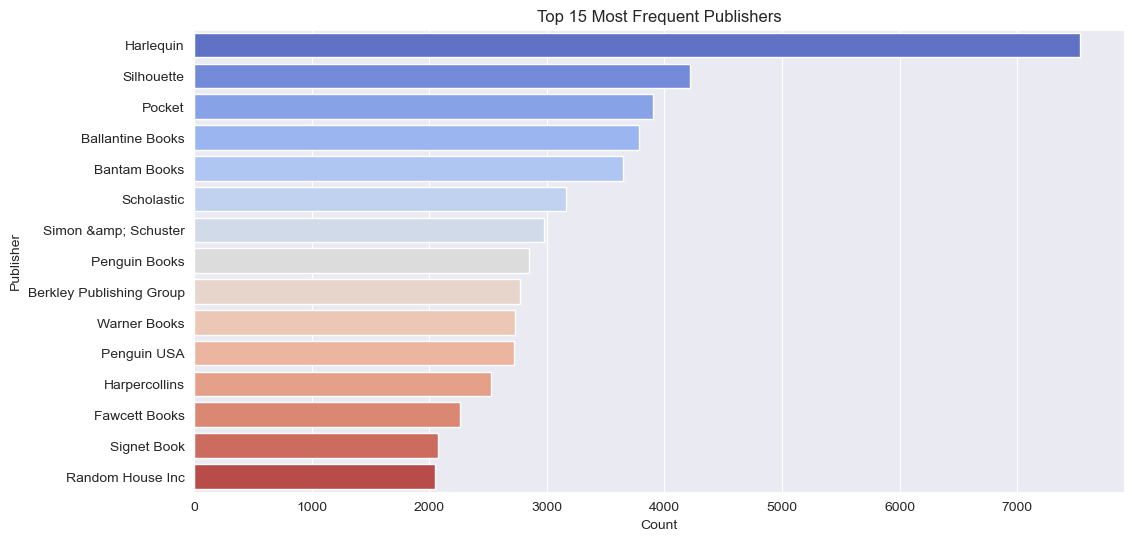

In [320]:
# Top 15 Publishers
top_publishers = books['Publisher'].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_publishers.values, y=top_publishers.index, hue=top_publishers.index, legend=False, palette="coolwarm")
plt.title("Top 15 Most Frequent Publishers")
plt.xlabel("Count")
plt.ylabel("Publisher")
plt.show()

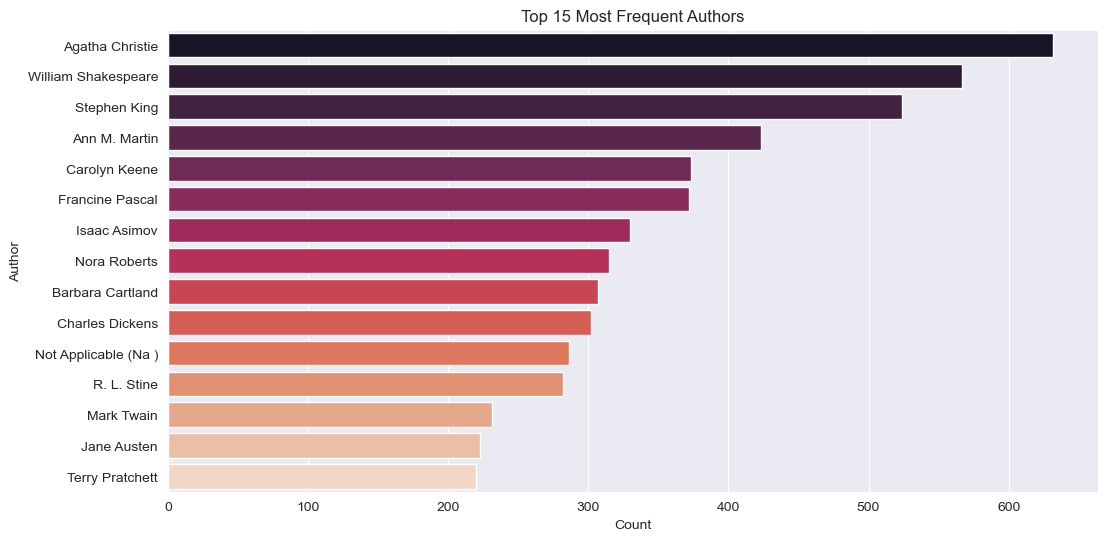

In [321]:
# Top 15 Authors
top_authors = books['Book-Author'].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_authors.values, y=top_authors.index, hue=top_authors.index, legend=False, palette="rocket")
plt.title("Top 15 Most Frequent Authors")
plt.xlabel("Count")
plt.ylabel("Author")
plt.show()

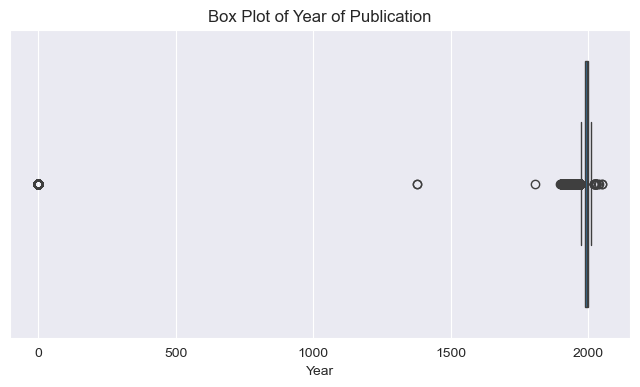

In [322]:
# Check outlier 
temp_books = books.copy()
temp_books['Year-Of-Publication'] = pd.to_numeric(temp_books['Year-Of-Publication'], errors='coerce')


plt.figure(figsize=(8, 4))
sns.boxplot(x=temp_books['Year-Of-Publication'].dropna() )
plt.title("Box Plot of Year of Publication")
plt.xlabel("Year")
plt.show()

Based on Image Box Plot of Year of Publication, there are a lot of outlier here. Outliers in this column could represent invalid or  data (e.g., years like 0 or less than 1500 years)

### Users Variable 

In [323]:
users.info() # Preview structure and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [324]:
users.describe() # Summary statistics

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [325]:
print("Missing values in Users:")
print(users.isnull().sum(), "\n") # Check missing value

Missing values in Users:
User-ID          0
Location         0
Age         110762
dtype: int64 



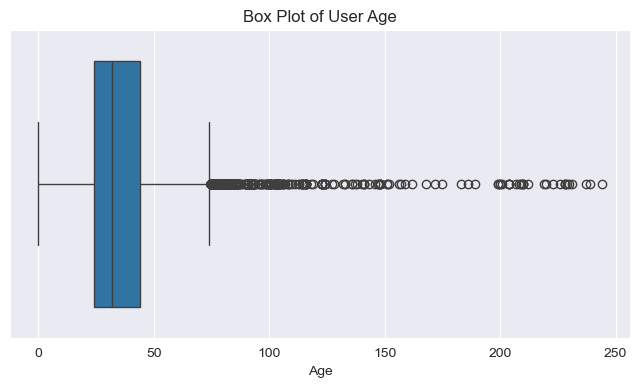

In [326]:
# Checking outliers on user based on age
plt.figure(figsize=(8, 4))
sns.boxplot(x=users['Age'])
plt.title("Box Plot of User Age")
plt.xlabel("Age")
plt.show()

Based on Box Plot of User Age box plot, in the Age column has Unreasonable outliers values, such as ages greater than 100 or 0. 

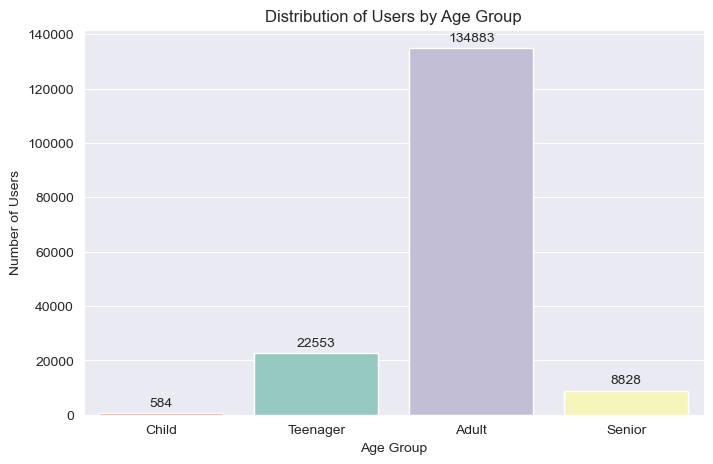

In [327]:
# Filter users with a realistic age range (5 to 100 years)
filtered_users = users[(users['Age'] >= 5) & (users['Age'] <= 100)].copy()

# Define age group categories
def get_age_group(age):
    if age <= 12:
        return 'Child'
    elif age <= 20:
        return 'Teenager'
    elif age <= 59:
        return 'Adult'
    else:
        return 'Senior'

# Apply age group categorization
filtered_users['AgeGroup'] = filtered_users['Age'].apply(get_age_group)


plt.figure(figsize=(8, 5))
ax = sns.countplot(data=filtered_users, x='AgeGroup', order=['Child', 'Teenager', 'Adult', 'Senior'], palette='Set3', hue='AgeGroup', legend=False)

# Add data labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)
    
plt.title("Distribution of Users by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Users")
plt.show()

### Ratings Variable

In [328]:
ratings.describe() # show summary

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [329]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [330]:
print(f"\nUnique User-ID: {ratings['User-ID'].nunique()}")
print(f"Unique ISBN: {ratings['ISBN'].nunique()}")
print(f"Most common rating: \n{ratings['Book-Rating'].value_counts().sort_index()}")


Unique User-ID: 105283
Unique ISBN: 340556
Most common rating: 
Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64


In [331]:
# Print the distribution of ratings from 0 to 10
rating_distribution = ratings['Book-Rating'].value_counts().sort_index()

# Display the distribution
print("Distribution of Ratings (0-10):")
print(rating_distribution)

Distribution of Ratings (0-10):
Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64


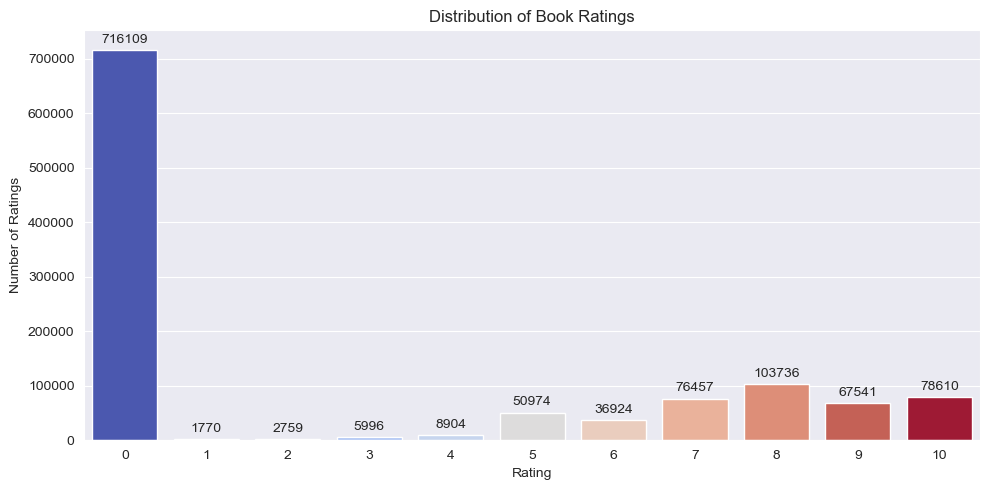

In [332]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Book-Rating', hue='Book-Rating', legend=False, data=ratings, palette='coolwarm')
plt.title("Distribution of Book Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")

# Add exact number above bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

Based on image of distribution ratings, there are users who reads but not give the ratings.

## Data Preparation

In this section, the data from the Books, Users, and Ratings datasets will be prepared for two recommendation methods: Content-Based Filtering and Collaborative Filtering. The steps include data cleaning, handling outliers, data merging, and feature transformation.

### Handling Missing Values

#### Books Dataset
* Fill the missing values in the `Book-Author` and `Publisher` columns with `'Unknown'`.
* Remove rows that have missing values in the `Image-URL-L` column.

This step is important to maintain the completeness of the book information that will be used in the recommendation process.


In [333]:
print("Missing values in books before handling:")
print(books.isnull().sum())

Missing values in books before handling:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


In [334]:
# Fill the missing values in Book-Author and Publisher with Unknown
books['Book-Author'] = books['Book-Author'].fillna('Unknown')
books['Publisher'] = books['Publisher'].fillna('Unknown')

In [335]:
# Drop missing values on Image-URL-L
books = books[books['Image-URL-L'].notnull()]

In [336]:
print("Missing values in books after handling:")
print(books.isnull().sum())
print(f"Final shape: {books.shape}")

Missing values in books after handling:
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64
Final shape: (271357, 8)


#### Users Dataset

* Missing age values will be filled with the **median** of the valid data.

In [337]:
print("Missing values in users before handling:")
print(users.isnull().sum())

Missing values in users before handling:
User-ID          0
Location         0
Age         110762
dtype: int64


In [338]:
# Fill remaining missing values with median age (from within the range)
median_age = users['Age'].median()
users['Age'].fillna(median_age)

print("Missing values in users after handling:")
print(users.isnull().sum())
print(f"Users cleaned shape: {users.shape}")

Missing values in users after handling:
User-ID          0
Location         0
Age         110762
dtype: int64
Users cleaned shape: (278858, 3)


### Handling Duplicates

* Remove duplicates based on the combination of `Book-Title` and `Book-Author` to ensure each book entry is unique.

In [339]:
print("Duplicate values in books before handling:")
print(books.duplicated(subset=['Book-Title', 'Book-Author']).sum())

Duplicate values in books before handling:
20175


In [340]:
# Remove duplicates based on Book-Title and Book-Author
books = books.drop_duplicates(subset=['Book-Title', 'Book-Author'], keep='first').reset_index(drop=True)

In [341]:
print("Duplicate values in books after handling:")
print(books.duplicated(subset=['Book-Title', 'Book-Author']).sum())

Duplicate values in books after handling:
0


### Handling Outliers

#### Books Dataset

* The `Year-Of-Publication` column contains unrealistic values, such as the year 0 or years far in the future.
* The Interquartile Range (IQR) method is used to remove outliers in the `Year-Of-Publication` column.

In [342]:
# Copy and convert year column to numeric
temp_books = books.copy()
temp_books['Year-Of-Publication'] = pd.to_numeric(temp_books['Year-Of-Publication'], errors='coerce')

In [343]:
# Drop NaN for analysis
year_data = temp_books['Year-Of-Publication'].dropna()

In [344]:
# Handling the Outlier with IQR
Q1 = year_data.quantile(0.25)
Q3 = year_data.quantile(0.75)
IQR = Q3 - Q1

# Define acceptable range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"Acceptable Year Range: {int(lower_bound)} to {int(upper_bound)}")

IQR: 11.0
Acceptable Year Range: 1972 to 2016


In [345]:
# Apply only years within the IQR range
books = temp_books[(temp_books['Year-Of-Publication'] >= lower_bound) & 
                   (temp_books['Year-Of-Publication'] <= upper_bound)]

print(f"Remaining data shape after outlier removal: {books.shape}")

Remaining data shape after outlier removal: (242904, 8)


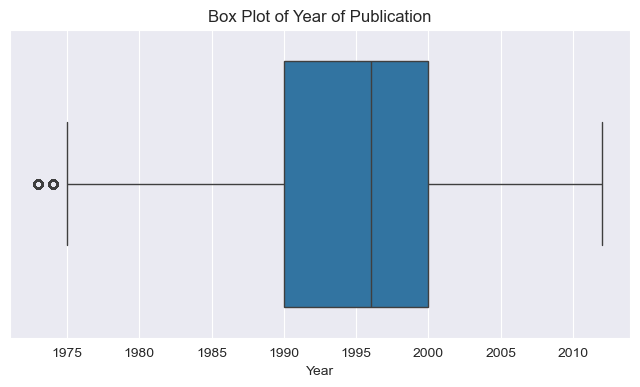

In [346]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=books['Year-Of-Publication'])
plt.title("Box Plot of Year of Publication")
plt.xlabel("Year")
plt.show()

#### Users Dataset

* A filter is applied to ensure that age data is only within the range of 5 to 100 years.


In [347]:
# Copy and filter the valid age ranges
users_cleaned = users.copy()
users_cleaned = users_cleaned[(users_cleaned['Age'] >= 5) & (users_cleaned['Age'] <= 100)]

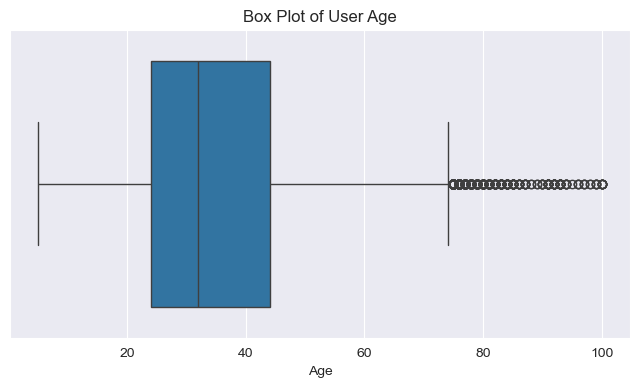

In [348]:
# Checking outliers on user based on age
plt.figure(figsize=(8, 4))
sns.boxplot(x=users_cleaned['Age'])
plt.title("Box Plot of User Age")
plt.xlabel("Age")
plt.show()

#### Ratings Dataset
Users have read the book, but they don't give the feedback. So, rating 0 is dropped

In [349]:
ratings_cleaned = ratings[ratings['Book-Rating'] > 0].copy()
print(f"Ratings after removing: {ratings_cleaned.shape}")

Ratings after removing: (433671, 3)


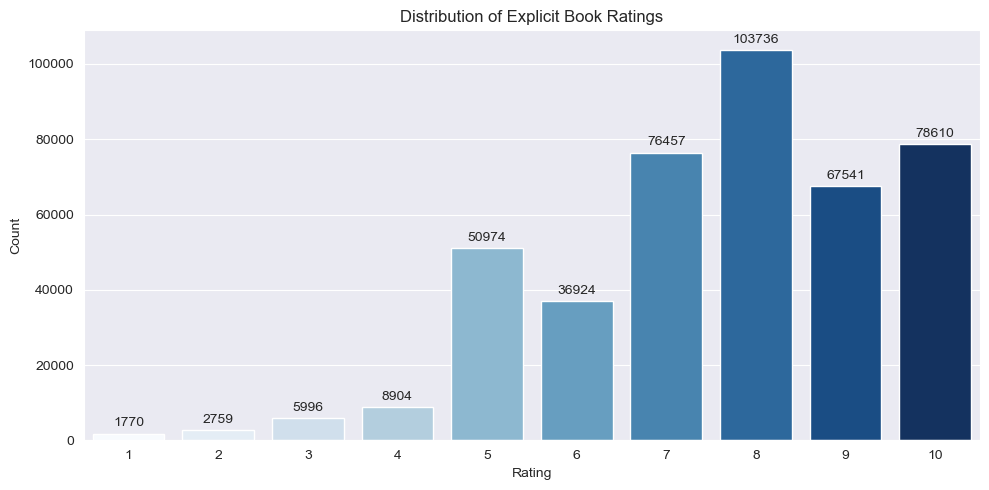

In [350]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Book-Rating', hue='Book-Rating', legend=False, data=ratings_cleaned, palette='Blues')
plt.title("Distribution of Explicit Book Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")

# Add labels on bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

### Merge Cleaned Data

After the data is cleaned, the datasets are merged as follows:

1. `ratings_cleaned` + `books`
2. The result is then merged with `users_cleaned`

This produces a comprehensive dataset for both Content-Based Filtering and Collaborative Filtering.

In [351]:
# Merger Ratings and Books
ratings_books = ratings_cleaned.merge(books, on='ISBN', how='inner')
print(f"Merged (ratings + books): {ratings_books.shape}")

Merged (ratings + books): (330700, 10)


In [352]:
# Merger with users
full_data = ratings_books.merge(users_cleaned, on='User-ID', how='inner')
print(f"Final merged shape (ratings + books + users): {full_data.shape}")

Final merged shape (ratings + books + users): (231693, 12)


In [353]:
full_data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,"rijeka, n/a, croatia",16.0
1,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,"rijeka, n/a, croatia",16.0
2,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,"iowa city, iowa, usa",25.0
3,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995,Pocket,http://images.amazon.com/images/P/0671537458.0...,http://images.amazon.com/images/P/0671537458.0...,http://images.amazon.com/images/P/0671537458.0...,"iowa city, iowa, usa",25.0
4,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997,Vintage Books USA,http://images.amazon.com/images/P/0679776818.0...,http://images.amazon.com/images/P/0679776818.0...,http://images.amazon.com/images/P/0679776818.0...,"iowa city, iowa, usa",25.0


### Content Based Filtering (CBF) Preparation
* Use the `Book-Title`, `Book-Author`, `Publisher`, and `Image-URL-L` columns to construct features.
* Combine the book title and author into a single string for further analysis.
* Use **TF-IDF Vectorizer** to convert the text into numerical features.

In [354]:
# Check the data
print(full_data.info())
print(full_data.describe())

# Create a copy of full_data for CBF modeling and using used columns
cbf_data = full_data[['Book-Title', 'Book-Author', 'Publisher', 'Image-URL-L']].copy()
print(f"CBF data shape: {cbf_data.shape}")


# Combine book title and author for TF-IDF
cbf_data['Book-Title-Author'] = cbf_data['Book-Title'] + ' ' + cbf_data['Book-Author']

# TF-IDF Vectorizer for combined features
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(cbf_data['Book-Title-Author'])

# Get the vocabulary
vocab = tfidf.get_feature_names_out()
print(f"Unique features (token): {len(vocab)}")

# Create lowercase index mapping for book title
cbf_data['Book-Title-Lower'] = cbf_data['Book-Title'].str.lower()

indices = pd.Series(cbf_data.index, index=cbf_data['Book-Title-Lower']).drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231693 entries, 0 to 231692
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              231693 non-null  int64  
 1   ISBN                 231693 non-null  object 
 2   Book-Rating          231693 non-null  int64  
 3   Book-Title           231693 non-null  object 
 4   Book-Author          231693 non-null  object 
 5   Year-Of-Publication  231693 non-null  int64  
 6   Publisher            231693 non-null  object 
 7   Image-URL-S          231693 non-null  object 
 8   Image-URL-M          231693 non-null  object 
 9   Image-URL-L          231693 non-null  object 
 10  Location             231693 non-null  object 
 11  Age                  231693 non-null  float64
dtypes: float64(1), int64(3), object(8)
memory usage: 21.2+ MB
None
             User-ID   Book-Rating  Year-Of-Publication            Age
count  231693.000000  231693.00000  

### Collaborative Filtering (CF) Preparation
* Use the `User-ID`, `ISBN`, and `Book-Rating` columns to build features.
* Apply `LabelEncoder` to convert the `User-ID` and `ISBN` columns into numerical format.
* Normalize the ratings to a \[0, 1] range to match the sigmoid output of the model.
* Split the data into 80% for training and 20% for testing.

In [355]:
# Check the data
print(full_data.info())
print(full_data.describe())

# Create a copy of full_data for CF modeling and using used columns
cf_data = full_data[['User-ID', 'ISBN', 'Book-Rating']].copy()
print(f"CF data shape: {cf_data.shape}")

# Encode User-ID and ISBN to Integer
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

cf_data['user'] = user_encoder.fit_transform(cf_data['User-ID'])
cf_data['item'] = item_encoder.fit_transform(cf_data['ISBN'])

# Convert rating to float
cf_data['rating'] = cf_data['Book-Rating'].astype(float)
# Normalize ratings to range [0, 1]
min_rating = cf_data['rating'].min()
max_rating = cf_data['rating'].max()
cf_data['rating'] = cf_data['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

# Get only used columns
cf_data = cf_data[['user', 'item', 'rating']]
print(f"CF data after preparation: {cf_data.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231693 entries, 0 to 231692
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              231693 non-null  int64  
 1   ISBN                 231693 non-null  object 
 2   Book-Rating          231693 non-null  int64  
 3   Book-Title           231693 non-null  object 
 4   Book-Author          231693 non-null  object 
 5   Year-Of-Publication  231693 non-null  int64  
 6   Publisher            231693 non-null  object 
 7   Image-URL-S          231693 non-null  object 
 8   Image-URL-M          231693 non-null  object 
 9   Image-URL-L          231693 non-null  object 
 10  Location             231693 non-null  object 
 11  Age                  231693 non-null  float64
dtypes: float64(1), int64(3), object(8)
memory usage: 21.2+ MB
None
             User-ID   Book-Rating  Year-Of-Publication            Age
count  231693.000000  231693.00000  

In [356]:
# Create the input array X (pairs of user and item)
X = cf_data[['user', 'item']].values

# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,           # Input: user-item pairs
    cf_data['rating'].values,  # Target: normalized ratings
    test_size=0.2,
    random_state=42
)
print(f"X_train shape : {X_train.shape}")
print(f"X_test shape  : {X_test.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"y_test shape  : {y_test.shape}")

X_train shape : (185354, 2)
X_test shape  : (46339, 2)
y_train shape : (185354,)
y_test shape  : (46339,)


## Modelling and Results

### Model Development with Content Based Filtering (CBF)
Steps development to build a content-based recommendation system:
1. **Recommendation Function**  
   - Built `get_book_recommendations()` to:
     - Compute cosine similarity between books.
     - Filter out duplicate or overly similar titles.
     - Apply a **maximum author ratio** to ensure recommendation diversity.
     - Return top-k similar but diverse books.

2. **Visualization**  
   - Implemented `plot_recommended_books()` to display recommended books in a grid layout with cover images and titles.

3. **Evaluation**  
   - Defined `precision_at_k()` and `recall_at_k()` to measure how relevant the top-k recommended books are.
   - Evaluated the overall system using `evaluate_recommendations()` by comparing output with known relevant titles.

In [357]:
def normalize_title(title):
    title = title.lower()
    title = re.sub(r'[^a-z\s]', '', title)  # remove digits/punctuation
    title = re.sub(r'\s+', ' ', title).strip()
    return title

 `normalize_title()` Function

This helper function is used to clean and standardize book titles for comparison purposes.  
It performs the following operations:
- Converts all characters to lowercase.
- Removes digits and punctuation using regular expressions.
- Strips extra spaces and ensures a clean, uniform format.

This normalization step helps improve the accuracy of similarity checks and avoids issues caused by inconsistent title formatting.


In [358]:
def safe_display_image(url, width=100):
    if isinstance(url, str) and url.startswith('http'):
        try:
            # Display the image from URL
            display(Image(url=url, width=width))
        except:
            print("[Image not available]")
    elif isinstance(url, str):
        try:
            # Open the image with PIL and display it
            img = ImagePIL.open(url)
            display(img)
        except Exception as e:
            print(f"[Error displaying local image: {e}]")
    else:
        print("[No valid image URL or path]")

`safe_display_image()` Function

This function is used to safely display book cover images within the notebook interface.

It handles two types of image sources:
- **URL-based images**: If the image URL is valid and begins with `http`, it attempts to fetch and display the image using the `IPython.display.Image` function.
- **Local images**: If the image path refers to a local file, it attempts to open and display it using `PIL.Image`.

If the image cannot be loaded or the path is invalid, the function prints an appropriate error message.  
This function ensures that image rendering does not break the notebook execution in case of invalid or missing image references.

`get_book_recommendations()` Function

This function returns the top-k book recommendations based on cosine similarity using TF-IDF features of book titles and authors.

Key Features:
- **Input:** A book title (`title`), number of recommendations (`k`), and a maximum author ratio (`max_author_ratio`).
- **Cosine Similarity:** Computes the similarity between the input book and all others using the TF-IDF matrix.
- **Diversity Constraint:** Limits the number of recommendations from the same author to avoid repetition.
- **Duplicate Filtering:** Removes semantic duplicates, such as books with the same normalized title and author.
- **Title Normalization:** Uses a helper function to clean and standardize titles before comparison.
- **Image Preview:** Displays the cover image of the input book and each recommended book.

Output:
- A list of recommended books (title, author, publisher, and image).
- A list of their corresponding indices in the dataset.

In [359]:
def get_book_recommendations(title, k=5, max_author_ratio=0.3):
    """
    Return top-k diverse books based on TF-IDF cosine similarity.
    Limits max percentage of books from the same author.
    Excludes semantic duplicates based on normalized title + author.
    """
    title = title.lower()

    # Check if the title exists in the index
    if title not in indices:
        print(f"Book title '{title}' not found in the dataset.")
        return [], []

    idx = indices[title]
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]

    # Check if the index is valid
    if idx >= tfidf_matrix.shape[0]:
        print(f"Index {idx} is out of range for the TF-IDF matrix.")
        return [], []

    # Normalize input title and author
    input_title_norm = normalize_title(cbf_data.loc[idx, 'Book-Title'])
    input_author = cbf_data.loc[idx, 'Book-Author'].lower()

    # Compute cosine similarity
    sim_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    top_indices = sim_scores.argsort()[::-1]

    # Author diversity filtering
    max_per_author = max(1, floor(k * max_author_ratio))
    author_counts = defaultdict(int)
    filtered = []

    # Filtering books to exclude duplicates and ensure diversity
    for i in top_indices:
        if i == idx:  # Skip the input book itself
            continue

        candidate = cbf_data.iloc[i]
        candidate_title_norm = normalize_title(candidate['Book-Title'])
        candidate_author = candidate['Book-Author'].lower()

        # Skip exact semantic duplicates (same title + author)
        if candidate_title_norm == input_title_norm and candidate_author == input_author:
            continue

        # Skip books that are too similar (same root title)
        if input_title_norm in candidate_title_norm:
            continue

        # Author diversity filter: limit the number of books from the same author
        if author_counts[candidate_author] >= max_per_author:
            continue

        # Add the recommended book to the list
        filtered.append(i)
        author_counts[candidate_author] += 1

        # Stop if reached the desired number of recommendations
        if len(filtered) == k:
            break

    if not filtered:
        print("No diverse recommendations found.")
        return [], []

    # Display input book
    print("\nInput Book:")
    input_book = cbf_data.loc[idx]
    print(f"Title     : {input_book['Book-Title']}")
    print(f"Author    : {input_book['Book-Author']}")
    print(f"Publisher : {input_book['Publisher']}")
    safe_display_image(input_book['Image-URL-L'], width=100)

    # Display top-k recommended books
    print(f"\nTop {k} Recommendations:\n")
    
    recommended_books = []
    for i, index in enumerate(filtered, start=1):
        rec = cbf_data.iloc[index]
        recommended_books.append({
            'title': rec['Book-Title'],
            'author': rec['Book-Author'],
            'publisher': rec['Publisher'],
            'image_url': rec['Image-URL-L']
        })
     

    # Return the filtered recommendations and top indices
    return recommended_books, filtered

In [360]:
get_book_recommendations("Harry Potter and the Prisoner of Azkaban")


Input Book:
Title     : Harry Potter and the Prisoner of Azkaban
Author    : J. K. Rowling
Publisher : Bloomsbury Pub Ltd



Top 5 Recommendations:



([{'title': 'Harry Potter and the Chamber of Secrets (Harry Potter)',
   'author': 'J. K. Rowling',
   'publisher': 'Arthur A. Levine Books',
   'image_url': 'http://images.amazon.com/images/P/0439554896.01.LZZZZZZZ.jpg'},
  {'title': "Harry Potter, tome 3 : Harry Potter et le Prisonnier d'Azkaban",
   'author': 'Joanne K. Rowling',
   'publisher': 'Gallimard',
   'image_url': 'http://images.amazon.com/images/P/2070541304.01.LZZZZZZZ.jpg'},
  {'title': "Harry Potter and the Philosopher's Stone",
   'author': 'J.K. Rowling',
   'publisher': 'BBC Consumer Publishing',
   'image_url': 'http://images.amazon.com/images/P/185549860X.01.LZZZZZZZ.jpg'},
  {'title': 'J. K. Rowling: The Wizard Behind Harry Potter',
   'author': 'Marc Shapiro',
   'publisher': "St. Martin's Press",
   'image_url': 'http://images.amazon.com/images/P/0312272243.01.LZZZZZZZ.jpg'},
  {'title': 'New Clues to Harry Potter Book 5: Hints from the Ultimate Unofficial Guide to the Mysteries of Harry Potter',
   'author': '

#### Visualize the results from Content Based Filtering (CBF)

`plot_recommended_books()` Function

This function visualizes the recommended books by displaying their cover images and titles in a horizontal grid layout.

Key Features:
- **Input:** A list of recommended books (each with `title` and `image_url`) and an optional column count `n`.
- **Image Fetching:** Retrieves images from URLs using HTTP requests and displays them using `PIL.Image`.
- **Fallback Handling:** If an image cannot be loaded, a placeholder message is displayed instead.
- **Layout:** Displays all book covers in a single row, with each subplot containing the image and book title.
- **Presentation:** Enhances the visual appeal of recommendations, making it easier to understand and evaluate results.

This visualization function is especially useful after calling `get_book_recommendations()` to provide a user-friendly display of the output.

In [361]:
def plot_recommended_books(recommended_books, n=3):
    """
    Visualize the list of recommended books with images and titles in a grid.
    The number of columns is based on 'n'.
    """
    if not recommended_books:
        print("No recommendations to display.")
        return

    # Extract book titles and image URLs from the recommended books
    book_titles = [book['title'] for book in recommended_books[0]]
    image_urls = [book['image_url'] for book in recommended_books[0]]

    # Calculate number of rows needed
    num_books = len(book_titles)
 
    
    fig, axes = plt.subplots(1, num_books, figsize=(num_books * 4, 6))  # One row, 'n' columns

    # Loop through each book and display its image and title in the grid
    for i, (title, img_url) in enumerate(zip(book_titles, image_urls)):
        ax_image = axes[i]  # Get the appropriate subplot axis

 
        # Fetch the image with requests and open it using PIL
        try:
            headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
            response = requests.get(img_url, headers=headers)  
            img = ImagePIL.open(BytesIO(response.content))  
            ax_image.imshow(img)
        except:
            ax_image.text(0.5, 0.5, 'Image Not Available', ha='center', va='center', fontsize=12)
            ax_image.axis('off')

        # Add title
        ax_image.set_title(title, fontsize=10, ha='center', wrap=True)
        ax_image.axis('off')  # Turn off axis for image
    

    # Remove any extra axes if there are more subplots than books
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Add a title for the overall plot
    plt.suptitle('Top Recommended Books', fontsize=16)

    # Display the plot
    plt.tight_layout()
 
    plt.show()


Input Book:
Title     : Harry Potter and the Prisoner of Azkaban
Author    : J. K. Rowling
Publisher : Bloomsbury Pub Ltd



Top 5 Recommendations:



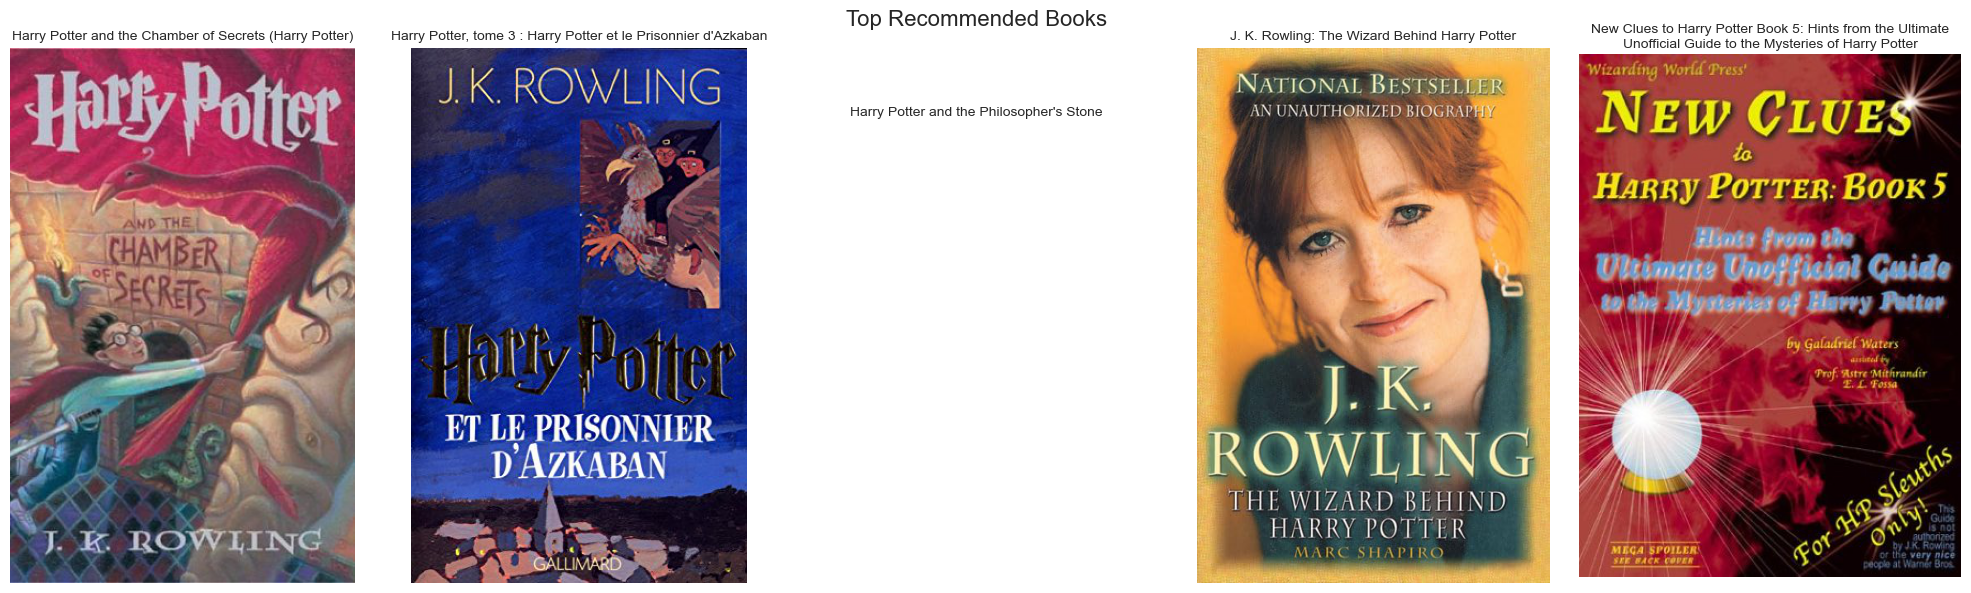

In [362]:
book_recommendation = get_book_recommendations("Harry Potter and the Prisoner of Azkaban")
plot_recommended_books(book_recommendation)

####  Evaluation Content Based Filtering (CBF)

These functions are used to evaluate the performance of the recommendation system using standard information retrieval metrics:

---

**`precision_at_k()`**  
- Calculates **Precision@K**, which measures how many of the top-K recommended books are actually relevant.
- Compares recommended book titles with a set of known relevant titles using case-insensitive substring matching.
- Returns the ratio of relevant recommendations to total relevant books.

---

**`recall_at_k()`**  
- Calculates **Recall@K**, which measures how many of the relevant books are captured in the top-K recommendations.
- Helps assess the system’s ability to retrieve all relevant items from the dataset.
- Also uses substring matching for evaluation.

---

**`evaluate_recommendations()`**  
- Runs `precision_at_k()` and `recall_at_k()` for a dictionary of test cases.
- Each test case contains a book title (as input) and a list of relevant book titles.
- Prints intermediate results for debugging and computes the average precision and recall across all test cases.

These metrics help measure both the **accuracy** (precision) and **completeness** (recall) of the recommendation.

In [363]:
def precision_at_k(recommended_books, relevant_books, k):
    """
    Calculate Precision@K for a given set of recommended books and relevant books.
    """
    recommended_books = recommended_books[:k]
    relevant_books = set(relevant_books)

    relevant_in_top_k = 0

    # Use a set to store unique recommended books and avoid duplicate counts
    recommended_books = set(recommended_books)

    # Check if any part of the input title appears in the recommended book titles
    for rec_book in recommended_books:
        for rel_book in relevant_books:
            # Convert to lowercase for case-insensitive matching
            if rel_book.lower() in rec_book.lower():  # Simple substring match
                relevant_in_top_k += 1
                break

    return relevant_in_top_k / len(relevant_books) if relevant_books else 0

def recall_at_k(recommended_books, relevant_books, k):
    """
    Calculate Recall@K for a given set of recommended books and relevant books.
    """
    recommended_books = recommended_books[:k]
    relevant_books = set(relevant_books)

    relevant_in_top_k = 0

    # Check if any part of the input title appears in the recommended book titles
    for rec_book in recommended_books:
        for rel_book in relevant_books:
            # Convert to lowercase for case-insensitive matching
            if rel_book.lower() in rec_book.lower():  # Simple substring match
                relevant_in_top_k += 1
                break

    return relevant_in_top_k / len(relevant_books) if relevant_books else 0

def evaluate_recommendations(test_data, k=5):
    """
    Evaluate the recommendation function using Precision@K and Recall@K.
    """
    precision_scores = []
    recall_scores = []

    for title, relevant_books in test_data.items():
        # Get recommendations
        result = get_book_recommendations(title, k=k)

        if result is None:
            print(f"No recommendations found for '{title}'. Skipping...")
            continue

        filtered, top_indices = result


        # Collect recommended book titles
        recommended_books = [cbf_data.iloc[i]['Book-Title'] for i in top_indices[:k]]
        
         # Debugging prints
        print(f"Title: {title}")
        print(f"Recommended Books: {recommended_books}")
        print(f"Relevant Books: {relevant_books}")

        # Calculate metrics
        precision = precision_at_k(recommended_books, relevant_books, k)
        recall = recall_at_k(recommended_books, relevant_books, k)

        precision_scores.append(precision)
        recall_scores.append(recall)

    # Average metrics
    avg_precision = np.mean(precision_scores) if precision_scores else 0
    avg_recall = np.mean(recall_scores) if recall_scores else 0

    return {
        'Precision@K': avg_precision,
        'Recall@K': avg_recall
    }


In [364]:
# Example test data
test_data = {
    "Harry Potter and the Prisoner of Azkaban": ["Harry Potter and the Chamber of Secrets (Harry Potter)","Philosopher's Stone"],
 
}

# Evaluate the recommendations
results = evaluate_recommendations(test_data, k=5)
print("Evaluation Results:", results)


Input Book:
Title     : Harry Potter and the Prisoner of Azkaban
Author    : J. K. Rowling
Publisher : Bloomsbury Pub Ltd



Top 5 Recommendations:

Title: Harry Potter and the Prisoner of Azkaban
Recommended Books: ['Harry Potter and the Chamber of Secrets (Harry Potter)', "Harry Potter, tome 3 : Harry Potter et le Prisonnier d'Azkaban", "Harry Potter and the Philosopher's Stone", 'J. K. Rowling: The Wizard Behind Harry Potter', 'New Clues to Harry Potter Book 5: Hints from the Ultimate Unofficial Guide to the Mysteries of Harry Potter']
Relevant Books: ['Harry Potter and the Chamber of Secrets (Harry Potter)', "Philosopher's Stone"]
Evaluation Results: {'Precision@K': 1.0, 'Recall@K': 1.0}


### Model Development with Collaborative Filtering (CF)
Steps the development of the collaborative filtering recommendation system:
1. **Model Architecture**
   - Defined a neural network model `RecommenderNet` using Keras.
   - Model includes:
     - User and item embeddings to learn latent factors.
     - Bias terms for both user and item.
     - A dot product of embeddings combined with biases.
     - A sigmoid activation function to produce the predicted rating.

2. **Model Compilation and Training**
   - Compiled the model using:
     - Loss function: Mean Squared Error (MSE).
     - Optimizer: Adam with a learning rate of 0.001.
     - Metrics: Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE).
   - Trained the model using `model.fit()` with training and validation data.

3. **Generating Recommendations**
   - Implemented `show_high_rated_book_and_recommendation()` to:
     - Display books highly rated by a user.
     - Recommend top-k new books the user has not rated, based on the model’s predicted scores.
     - Show book details and cover images.
          
4. **Model Evaluation**
   - Created `plot_training_history()` to visualize:
     - Training and validation loss (MSE)
     - RMSE and MAE over training epochs.
   - These visualizations help identify convergence behavior and potential overfitting.


`RecommenderNet` Class (Collaborative Filtering Model)

This class defines a neural network-based collaborative filtering model using **matrix factorization with embeddings**.  
It predicts the interaction (rating) between a user and a book based on learned latent features.

Key Components:
- **User Embeddings:** Maps each user to a latent vector representation.
- **Item Embeddings:** Maps each book/item to a latent vector.
- **Bias Terms:** Includes bias embeddings for both users and items to improve prediction accuracy.
- **Dot Product Layer:** Multiplies user and item vectors to compute interaction strength.
- **Sigmoid Activation:** Applies a sigmoid to constrain the output between 0 and 1, suitable for normalized ratings.

Constructor Parameters:
- `num_users`: Total number of unique users in the dataset.
- `num_items`: Total number of unique items (books).
- `embedding_size`: Dimension of the latent feature space (default = 50).

Output:
- The model returns a predicted rating score between 0 and 1 for each user-item pair.

This model is used in collaborative filtering, where recommendations are made based on user behavior patterns rather than item content.

In [365]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        
        # User embedding
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(input_dim=num_users, output_dim=1)

        # Item embedding
        self.item_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.item_bias = layers.Embedding(input_dim=num_items, output_dim=1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0]) # Call layer embedding 1
        user_bias = self.user_bias(inputs[:, 0])        # Call layer embedding 2
        item_vector = self.item_embedding(inputs[:, 1]) # Call layer embedding 3
        item_bias = self.item_bias(inputs[:, 1])        # Call layer embedding 4

        dot_user_item = tf.reduce_sum(user_vector * item_vector, axis=1, keepdims=True)
        result = dot_user_item + user_bias + item_bias

        return tf.nn.sigmoid(result)

Initializes and compiles the `RecommenderNet` model for collaborative filtering.

 Steps:
- **Get Dimensions:**
  - `num_users`: The number of unique users in the dataset.
  - `num_items`: The number of unique books/items.

- **Model Initialization:**
  - Creates an instance of the `RecommenderNet` class using the user and item counts.

- **Model Compilation:**
  - **Loss Function:** `Mean Squared Error (MSE)` is used to measure the difference between predicted and actual ratings.
  - **Optimizer:** `Adam` optimizer with a learning rate of `0.001` is used for efficient gradient updates.
  - **Evaluation Metrics:**
    - `RootMeanSquaredError (RMSE)`: Measures the standard deviation of prediction errors.
    - `MeanAbsoluteError (MAE)`: Measures the average magnitude of the errors.

This setup prepares the model for training and evaluation using normalized rating data.

In [366]:
# Get user and item dimensions
num_users = cf_data['user'].nunique()
num_items = cf_data['item'].nunique()

# Build model
model = RecommenderNet(num_users, num_items)
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError()
    ]
)

Trains the `RecommenderNet` model using the prepared training and validation datasets.

Parameters:
- **`x=X_train`**: Input data consisting of user-item pairs.
- **`y=y_train`**: Target values, i.e., normalized ratings for the user-item pairs.
- **`batch_size=64`**: Number of samples processed before the model updates.
- **`epochs=10`**: Number of complete passes through the training dataset.
- **`verbose=1`**: Displays progress during training.
- **`validation_data=(X_test, y_test)`**: Evaluation data used to monitor overfitting and generalization performance after each epoch.

 Output:
- The model returns a `history` object containing the training and validation metrics (loss, RMSE, and MAE) for each epoch.  
This object can be used later to visualize the learning curve and evaluate model performance over time.

In [367]:
# Training
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(X_test, y_test)
)

Epoch 1/10
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 65s 22ms/step - loss: 0.0916 - mean_absolute_error: 0.2627 - root_mean_squared_error: 0.3021 - val_loss: 0.0672 - val_mean_absolute_error: 0.2173 - val_root_mean_squared_error: 0.2566
Epoch 2/10
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 64s 22ms/step - loss: 0.0598 - mean_absolute_error: 0.2003 - root_mean_squared_error: 0.2402 - val_loss: 0.0546 - val_mean_absolute_error: 0.1873 - val_root_mean_squared_error: 0.2272
Epoch 3/10
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 85s 23ms/step - loss: 0.0460 - mean_absolute_error: 0.1669 - root_mean_squared_error: 0.2065 - val_loss: 0.0486 - val_mean_absolute_error: 0.1740 - val_root_mean_squared_error: 0.2136
Epoch 4/10
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 58s 20ms/step - loss: 0.0386 - mean_absolute_error: 0.1499 - root_mean_squared_error: 0.1886 - val_loss: 0.0444 - val_mean_absolute_error: 0.1658 - val_root_mean_squared_error: 0.2052
Epoch 5/10
2897/2897 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - loss: 0.0336 - mean_absolute_error: 0.

#### Visualize Results Collaborative Filtering (CF)

`show_high_rated_book_and_recommendation()` Function

This function is used to:
1. Display the top books that a specific user has rated highly.
2. Generate and display personalized book recommendations using the trained collaborative filtering model.

Parameters:
- `original_user_id`: The real (non-encoded) user ID.
- `top_k`: Number of recommendations to show.
- `min_rating`: Minimum rating threshold to consider a book as highly rated.
- `top_k_rating`: Number of highly-rated books to display.

Process:
- **User Encoding:** The function converts the original user ID into the encoded format used by the model.
- **Top Rated Books:**
  - Filters books that the user has rated above the `min_rating` threshold.
  - Displays the top `top_k_rating` results along with their cover images.
- **Recommendation Generation:**
  - Identifies books that the user has not rated.
  - Predicts ratings for those books using the model.
  - Selects the top `top_k` books with the highest predicted scores.
  - Displays these recommendations with their titles, authors, publishers, and cover images.

Output:
- Textual and visual display of both highly-rated books and recommendations for the given user.


In [368]:
def show_high_rated_book_and_recommendation(original_user_id, top_k=5, min_rating=8.0, top_k_rating=3):
    # Encode user ID
    try:
        encoded_user_id = user_encoder.transform([original_user_id])[0]
    except ValueError:
        print(f"User-ID {original_user_id} not found in training data.")
        return pd.DataFrame()

    normalized_min_rating = (min_rating - min_rating) / (max_rating - min_rating)
    
    # Filter books rated ≥ min_rating by the user
    high_rated_df = cf_data[(cf_data['user'] == encoded_user_id) & (cf_data['rating'] >= normalized_min_rating)]
    
    # Sort by actual rating value (descending) and get top k__rating
    top_rated_df = high_rated_df.sort_values(by='rating', ascending=False).head(top_k_rating)
    
    # Decode item IDs to ISBNs
    high_rated_isbns = item_encoder.inverse_transform(top_rated_df['item'])
    
    # Lookup book details
    high_rated_books = books[books['ISBN'].isin(high_rated_isbns)][['Book-Title', 'Book-Author', 'Publisher', 'Image-URL-L']].drop_duplicates().reset_index(drop=True)
    
    print(f"\nTop {top_k_rating} Books rated ≥ {min_rating} by user {original_user_id}:\n")
    if high_rated_books.empty:
        print("No high-rated books found.")
    else:
        for i, row in high_rated_books.iterrows():
            print(f"#{i+1}: {row['Book-Title']} by {row['Book-Author']} ({row['Publisher']})")
            safe_display_image(row['Image-URL-L'])
            print("-" * 40)

    # Not rated Books → Recommendation
    user_all_rated_df = cf_data[cf_data['user'] == encoded_user_id]
    rated_items = user_all_rated_df['item'].values
    
    all_items = np.arange(num_items) # Create array
    unrated_items = np.setdiff1d(all_items, rated_items) # Get only unrated items from all items

    user_input = np.array([[encoded_user_id, item] for item in unrated_items]) # Create user - item to every unrated items
    
    #Predict using the model
    predicted_ratings = model.predict(user_input, verbose=0).flatten()

    top_indices = predicted_ratings.argsort()[-top_k:][::-1] # Get high prediction 
    
    recommended_item_ids = unrated_items[top_indices]
    recommended_isbns = item_encoder.inverse_transform(recommended_item_ids)
    
    # Get all recommendation book from books
    recommended_books = books[books['ISBN'].isin(recommended_isbns)][['Book-Title', 'Book-Author', 'Publisher', 'Image-URL-M']].drop_duplicates().reset_index(drop=True)

    print(f"\nTop {top_k} Book Recommendations for User {original_user_id}:\n")
    if recommended_books.empty:
        print("No recommendations available.")
    else:
        for i, row in recommended_books.iterrows():
            print(f"#{i+1}: {row['Book-Title']} by {row['Book-Author']} ({row['Publisher']})")
            safe_display_image(row['Image-URL-M'], width=100)
            print("-" * 40)

In [369]:
# Random users
unique_users = np.unique(X_train[:, 0])
original_user_ids = user_encoder.inverse_transform(unique_users)
random_user_id = random.choice(original_user_ids)
print(f"Get high rated books and recommendation for user ID: {random_user_id}")
show_high_rated_book_and_recommendation(random_user_id)

Get high rated books and recommendation for user ID: 196277

Top 3 Books rated ≥ 8.0 by user 196277:

#1: A Living Nightmare (Cirque du Freak, Book 1) by Darren Shan (Little, Brown)


----------------------------------------

Top 5 Book Recommendations for User 196277:

#1: Lonesome Dove by Larry McMurtry (Pocket)


----------------------------------------
#2: Free by Paul Vincent (Upfront Publishing)


----------------------------------------
#3: The Hobbit : The Enchanting Prelude to The Lord of the Rings by J.R.R. TOLKIEN (Del Rey)


----------------------------------------
#4: The Return of the King (The Lord of the Rings, Part 3) by J.R.R. TOLKIEN (Del Rey)


----------------------------------------
#5: Harry Potter and the Goblet of Fire (Book 4) by J. K. Rowling (Scholastic)


----------------------------------------


In [370]:
show_high_rated_book_and_recommendation(110887)


Top 3 Books rated ≥ 8.0 by user 110887:

#1: In the Heart of the Sea: The Tragedy of the Whaleship Essex by Nat Philbrick (Penguin Books)


----------------------------------------
#2: Driven by W. G. Griffiths (Warner Faith)


----------------------------------------
#3: About Three Bricks Shy of a Load by Mel Blount (Ballantine Books)


----------------------------------------

Top 5 Book Recommendations for User 110887:

#1: Lonesome Dove by Larry McMurtry (Pocket)


----------------------------------------
#2: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) by J. K. Rowling (Arthur A. Levine Books)


----------------------------------------
#3: Free by Paul Vincent (Upfront Publishing)


----------------------------------------
#4: The Return of the King (The Lord of the Rings, Part 3) by J.R.R. TOLKIEN (Del Rey)


----------------------------------------
#5: Harry Potter and the Goblet of Fire (Book 4) by J. K. Rowling (Scholastic)


----------------------------------------


#### Evaluation Collaborative Filtering (CF)

`plot_training_history()` Function

This function visualizes the performance of the collaborative filtering model during training and validation.

Input:
- `history`: The Keras `History` object returned by the `model.fit()` function, which contains loss and metric values recorded over epochs.

Visualization Output:
The function creates three subplots:
1. **Loss (MSE)**  
   - Plots training and validation Mean Squared Error over each epoch.
2. **RMSE (Root Mean Squared Error)**  
   - Displays how prediction error (in root scale) evolves for training and validation sets.
3. **MAE (Mean Absolute Error)**  
   - Tracks average prediction error magnitude over time.

Each subplot includes:
- Proper axis labels and titles.
- Legends for distinguishing training vs. validation.
- Grids for easier interpretation.


In [371]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Loss (MSE)
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # RMSE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
    plt.title('RMSE per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

    # MAE
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
    plt.title('MAE per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

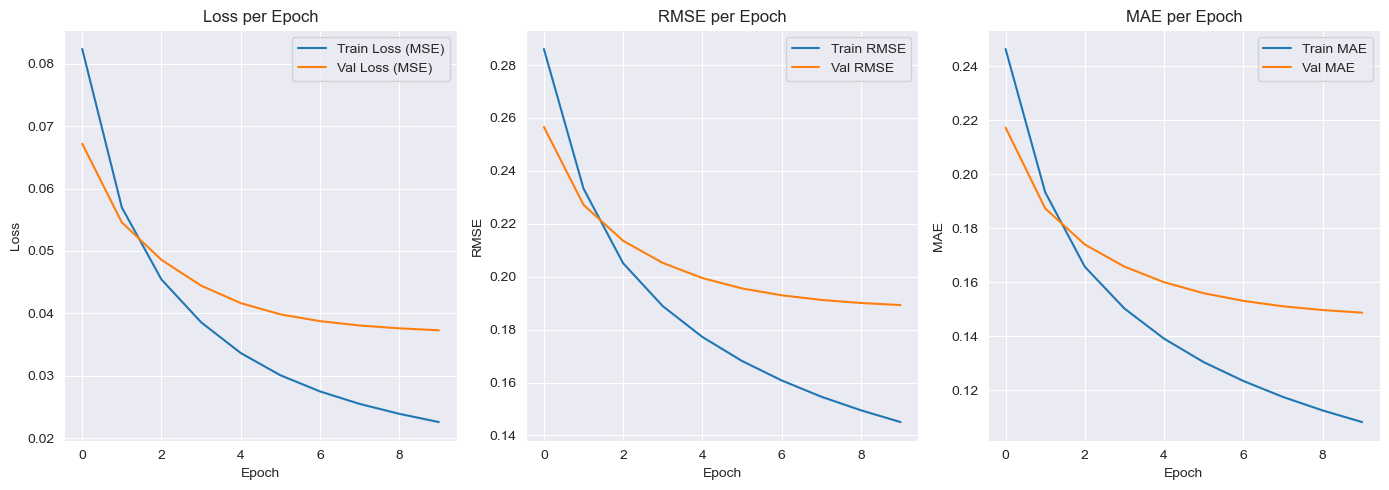

In [372]:
plot_training_history(history)